# Partie 1 : Transformation paramétrique du texte (pre-traitements)

Dans cette partie nous allons se familiarisé un peu avec des données avec l'extraction et la visualisation des données.

Nous allons tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

# Importation des bibliothéques

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spacy 
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (accuracy_score,f1_score,precision_score,recall_score,roc_auc_score)
from time import time
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


import utils as ut

[nltk_data] Downloading package punkt to /home/anyes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/anyes/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/anyes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/anyes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Etape 0 : Chargement de données movies

Dans cette partie nous allons rechargé les données de movies afin d'effectuer l'analyse de sentiments

In [5]:
path = "../datasets/movies/movies1000/"
alltxts,alllabs = ut.load_movies(path)

Création du DataFrame

In [6]:
movies_df = pd.DataFrame()
movies_df['text'] = alltxts
movies_df['label'] = alllabs

movies_df

,text,label
0,the kids in the hall are an acquired taste . \...,0
1,capsule : a science fiction allegory . \nat th...,0
2,there is a rule when it comes to movies . \na ...,0
3,it's amazing how a comedian can have the some ...,0
4,"absolute power , the new film produced and dir...",0
...,...,...
1995,"as i walked out of crouching tiger , hidden dr...",1
1996,"when andy leaves for cowboy camp , his mother ...",1
1997,plot : a bunch of bad guys dressed up as elvis...,1
1998,trees lounge is the directoral debut from one ...,1


# Etape 1 : Visualisation des données

Dans cette partie, nous allons faire quelques visualisations de données

## 1.1 Distribution des classes

D'aprés le graphe ci-dessous, on peut remarqué qu'il y a autant de review négatif que de review positif

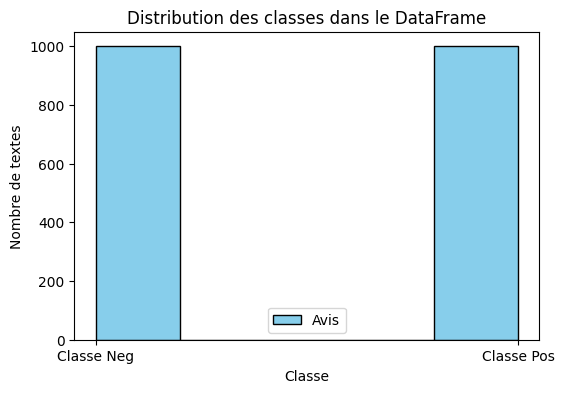

In [7]:

plt.figure(figsize=(6, 4))  # Définir la taille de la figure
plt.hist(movies_df['label'], bins=5, color='skyblue', edgecolor='black')  # Définir le nombre de bacs et les couleurs
plt.title('Distribution des classes dans le DataFrame')  # Ajouter un titre au graphique
plt.xlabel('Classe')  # Ajouter une étiquette pour l'axe x
plt.ylabel('Nombre de textes')  # Ajouter une étiquette pour l'axe y
plt.xticks([0, 1], labels=['Classe Neg', 'Classe Pos'])  # Définir les étiquettes de l'axe x
plt.legend(labels=['Avis'])  # Ajouter une légende
plt.show()


## 1.2 Longueur des textes

### 1.2.1 Sur tout le dataframe

Création d'une nouvelle colonne qui associe pour chaque text sa longueur, cela va nous permettre d'analyser les longueurs des texts

In [8]:
movies_df['text_length'] = movies_df['text'].apply(len)
movies_df

,text,label,text_length
0,the kids in the hall are an acquired taste . \...,0,2342
1,capsule : a science fiction allegory . \nat th...,0,1621
2,there is a rule when it comes to movies . \na ...,0,2525
3,it's amazing how a comedian can have the some ...,0,2572
4,"absolute power , the new film produced and dir...",0,4591
...,...,...,...
1995,"as i walked out of crouching tiger , hidden dr...",1,3607
1996,"when andy leaves for cowboy camp , his mother ...",1,5259
1997,plot : a bunch of bad guys dressed up as elvis...,1,5269
1998,trees lounge is the directoral debut from one ...,1,1088


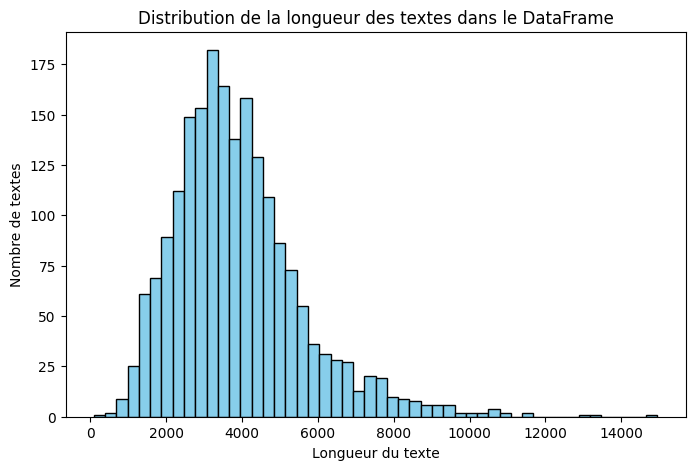

In [9]:
plt.figure(figsize=(8, 5))  # Définir la taille de la figure
plt.hist(movies_df['text_length'], bins=50, color='skyblue', edgecolor='black')  
plt.title('Distribution de la longueur des textes dans le DataFrame')  # Ajouter un titre au graphique
plt.xlabel('Longueur du texte')  # Ajouter une étiquette pour l'axe x
plt.ylabel('Nombre de textes')  # Ajouter une étiquette pour l'axe y
plt.show()

### 1.2.2 Par classe

D'aprés les graphes de distribution de la longueur des texts, on peut dire qu'à première vu les 2 classes ont la même distribution.

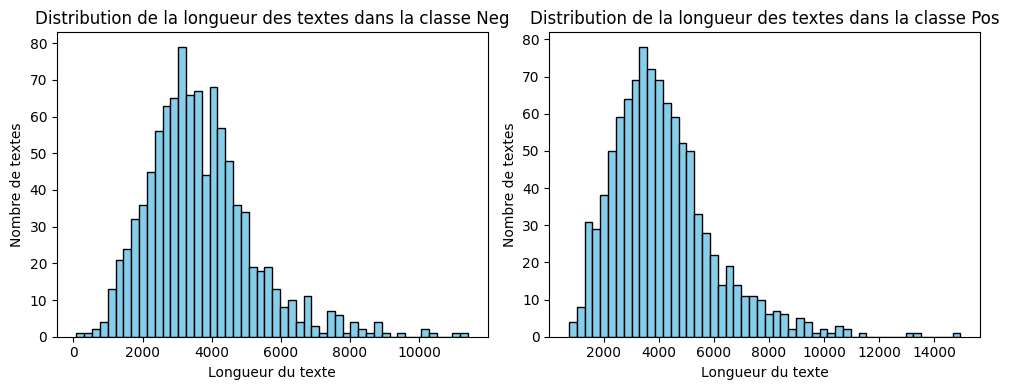

In [10]:
# Création des sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Affichage de l'histogramme de la longueur des textes
ax1.hist(movies_df[movies_df['label'] == 0]['text_length'], bins=50, color='skyblue', edgecolor='black')
ax1.set_title('Distribution de la longueur des textes dans la classe Neg')
ax1.set_xlabel('Longueur du texte')
ax1.set_ylabel('Nombre de textes')

# Affichage de l'histogramme de la distribution des classes
ax2.hist(movies_df[movies_df['label'] == 1]['text_length'], bins=50, color='skyblue', edgecolor='black')
ax2.set_title('Distribution de la longueur des textes dans la classe Pos')
ax2.set_xlabel('Longueur du texte')
ax2.set_ylabel('Nombre de textes')

# Afficher les sous-graphiques
plt.tight_layout()
plt.show()


# Etape 2 : Transformation paramétrique du texte (pré-traitements)


On teste les cas suivants:
- suppression de la ponctuation
- transformation en minuscule ou pas
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- lemmatization 

### 2.1 Suppression de la ponctuation

Commençons par la suppression de la ponctuation

In [11]:
text = movies_df.text[0]
print("Avant : \n" ,text)
text =  ut.remove_ponctuation(movies_df.text[0])
print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Apres :\n" ,text)

Avant : 
 the kids in the hall are an acquired taste . 
it took at least a season of watching their show on hbo before i became a believer . 
maybe after watching a half dozen kids in the hall movies , they would grow into the big screen . 
my recommendation is that , unless you are a big fan of the kids , skip the film . 
as it is , their first--and most likely only--attempt at a full length film lacks the qualities that made their comedy work on tv . 
a big-budget and glossy production can not make up for a lack of spontaneity that permeates their tv show . 
the kids go through the motions , but you get the feeling that they arent really having fun doing so . 
and this makes it more difficult for the audience to enjoy their antics . 
brain candy is a bunch of skits tied together by the story of a pharmaceutical company that develops a new drug to cure depression . 
in typical sketch-comedy tradition , each actor plays several roles . 
doctor cooper ( kevin mcdonald ) and his team cre

### 2.2 Suppression des nombres

In [12]:
text = movies_df.text[1001]
print("Avant :\n" ,text)
text =  ut.remove_numbers(text)
print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Apres :\n" ,text)

Avant :
 carry on matron is the last great carry-on film in my opinion . 
made in 1972 , it still features most of the regulars of this genre . 
sid james plays the head of a gang of crooks intent on stealing contraceptive pills from the local maternity hospital and selling them off to make a profit , kenneth williams is sir bernard cutting , head of the hospital but also a hypochondriac , hattie jacques re-takes her role as matron , and charles hawtrey is the psychiatrist dr . goode . 
the jokes come in fast and so do the laughs , with humorous antics between the matron and sir bernard . 
this time , williams is after matron ( jacques ) when he needs to prove himself that he is a man after visiting dr . goode . 
the doctor ( hawtrey ) is sworn to secrecy : - " i assure you , that anything you say to me today will go in one ear and straight out of the other ! " 
bernard thinks he is having a sex change and needs to prove himself . 
there are great cameos from joan sims , an expectant m

### 2.3 Suppression des noms de personne

A voir si on le fait ou pas, car la fonction qui supprime les noms supprime tous les noms qui commence par la majuscule en vrai

In [13]:
text = movies_df.text[1001]
print("Avant :\n" ,text)
text =  ut.remove_names_En(text)
print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Apres :\n" ,text)

Avant :
 carry on matron is the last great carry-on film in my opinion . 
made in 1972 , it still features most of the regulars of this genre . 
sid james plays the head of a gang of crooks intent on stealing contraceptive pills from the local maternity hospital and selling them off to make a profit , kenneth williams is sir bernard cutting , head of the hospital but also a hypochondriac , hattie jacques re-takes her role as matron , and charles hawtrey is the psychiatrist dr . goode . 
the jokes come in fast and so do the laughs , with humorous antics between the matron and sir bernard . 
this time , williams is after matron ( jacques ) when he needs to prove himself that he is a man after visiting dr . goode . 
the doctor ( hawtrey ) is sworn to secrecy : - " i assure you , that anything you say to me today will go in one ear and straight out of the other ! " 
bernard thinks he is having a sex change and needs to prove himself . 
there are great cameos from joan sims , an expectant m

### 2.4 Stemming

In [15]:
text = movies_df.text[0]
print("Avant :\n" ,text)
text =  ut.stemming_En(text)
print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Apres :\n" ,text)

Avant :
 the kids in the hall are an acquired taste . 
it took at least a season of watching their show on hbo before i became a believer . 
maybe after watching a half dozen kids in the hall movies , they would grow into the big screen . 
my recommendation is that , unless you are a big fan of the kids , skip the film . 
as it is , their first--and most likely only--attempt at a full length film lacks the qualities that made their comedy work on tv . 
a big-budget and glossy production can not make up for a lack of spontaneity that permeates their tv show . 
the kids go through the motions , but you get the feeling that they arent really having fun doing so . 
and this makes it more difficult for the audience to enjoy their antics . 
brain candy is a bunch of skits tied together by the story of a pharmaceutical company that develops a new drug to cure depression . 
in typical sketch-comedy tradition , each actor plays several roles . 
doctor cooper ( kevin mcdonald ) and his team crea

### 2.5 Lemmatization

Pour ce probléme d'analyse de sentiments, nous avons choisi d'utiliser la lemmatization au lieu du stemming car elle est plus précise, et l'analyse de texte pour la compréhension humaine nécessite plus de précision.

In [16]:
text = movies_df.text[1001]
print("Avant :\n" ,text)
text =  ut.lemmatization(text)
print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Apres :\n" ,text)

Avant :
 carry on matron is the last great carry-on film in my opinion . 
made in 1972 , it still features most of the regulars of this genre . 
sid james plays the head of a gang of crooks intent on stealing contraceptive pills from the local maternity hospital and selling them off to make a profit , kenneth williams is sir bernard cutting , head of the hospital but also a hypochondriac , hattie jacques re-takes her role as matron , and charles hawtrey is the psychiatrist dr . goode . 
the jokes come in fast and so do the laughs , with humorous antics between the matron and sir bernard . 
this time , williams is after matron ( jacques ) when he needs to prove himself that he is a man after visiting dr . goode . 
the doctor ( hawtrey ) is sworn to secrecy : - " i assure you , that anything you say to me today will go in one ear and straight out of the other ! " 
bernard thinks he is having a sex change and needs to prove himself . 
there are great cameos from joan sims , an expectant m

### 2.6 Suppression des stop words

In [17]:
text = movies_df.text[1001]
print("Avant :\n" ,text)
text =  ut.remove_stopwords_En(text)
print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Apres :\n" ,text)

Avant :
 carry on matron is the last great carry-on film in my opinion . 
made in 1972 , it still features most of the regulars of this genre . 
sid james plays the head of a gang of crooks intent on stealing contraceptive pills from the local maternity hospital and selling them off to make a profit , kenneth williams is sir bernard cutting , head of the hospital but also a hypochondriac , hattie jacques re-takes her role as matron , and charles hawtrey is the psychiatrist dr . goode . 
the jokes come in fast and so do the laughs , with humorous antics between the matron and sir bernard . 
this time , williams is after matron ( jacques ) when he needs to prove himself that he is a man after visiting dr . goode . 
the doctor ( hawtrey ) is sworn to secrecy : - " i assure you , that anything you say to me today will go in one ear and straight out of the other ! " 
bernard thinks he is having a sex change and needs to prove himself . 
there are great cameos from joan sims , an expectant m

### 2.7 Extraction de la premiére ligne

In [18]:
text = movies_df.text[0]
print("Avant :\n" ,text)
text =  ut.extraire_debut(text)
print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Apres :\n" ,text)

Avant :
 the kids in the hall are an acquired taste . 
it took at least a season of watching their show on hbo before i became a believer . 
maybe after watching a half dozen kids in the hall movies , they would grow into the big screen . 
my recommendation is that , unless you are a big fan of the kids , skip the film . 
as it is , their first--and most likely only--attempt at a full length film lacks the qualities that made their comedy work on tv . 
a big-budget and glossy production can not make up for a lack of spontaneity that permeates their tv show . 
the kids go through the motions , but you get the feeling that they arent really having fun doing so . 
and this makes it more difficult for the audience to enjoy their antics . 
brain candy is a bunch of skits tied together by the story of a pharmaceutical company that develops a new drug to cure depression . 
in typical sketch-comedy tradition , each actor plays several roles . 
doctor cooper ( kevin mcdonald ) and his team crea

### 2.8 Extracion de la derniére ligne

In [19]:
text = movies_df.text[0]
print("Avant :\n" ,text)
text =  ut.extraire_fin(text)
print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Apres :\n" ,text)

Avant :
 the kids in the hall are an acquired taste . 
it took at least a season of watching their show on hbo before i became a believer . 
maybe after watching a half dozen kids in the hall movies , they would grow into the big screen . 
my recommendation is that , unless you are a big fan of the kids , skip the film . 
as it is , their first--and most likely only--attempt at a full length film lacks the qualities that made their comedy work on tv . 
a big-budget and glossy production can not make up for a lack of spontaneity that permeates their tv show . 
the kids go through the motions , but you get the feeling that they arent really having fun doing so . 
and this makes it more difficult for the audience to enjoy their antics . 
brain candy is a bunch of skits tied together by the story of a pharmaceutical company that develops a new drug to cure depression . 
in typical sketch-comedy tradition , each actor plays several roles . 
doctor cooper ( kevin mcdonald ) and his team crea